In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u, constants as const
import sys
sys.path.append('/home/gusinskaia/screens')
#from screens.fields import dynamic_field, theta_grid
from screens.fields import dynamic_field

In [30]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [64]:
from glob import glob
import os, math, time
from astropy.time import Time
from astropy.visualization import quantity_support
from astropy import constants as const

import astropy
from matplotlib.colors import LogNorm,SymLogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth
import wsrt_fits as wf

import pickle
plt.rcParams['figure.dpi'] = 50

In [32]:
def get_models_from_recov(recov_E, dspec):
    model=np.fft.ifft2(np.fft.ifftshift(recov_E)).real
    model_E=np.fft.ifft2(np.fft.ifftshift(recov_E))[:dspec.shape[0],:dspec.shape[1]]
    model_E_ev=model_E[:dspec.shape[0],:dspec.shape[1]]
    model_E_ev=np.pad(model_E_ev,
                    (   (0,SS.shape[0]-model_E_ev.shape[0]),
                        (0,SS.shape[1]-model_E_ev.shape[1])),
                    mode='constant',
                    constant_values=model_E_ev.mean())
    model_field_ev=np.abs(np.fft.fftshift(np.fft.fft2(model_E_ev)))**2
    model_E_ev=model_E_ev[:dspec.shape[0],:dspec.shape[1]].T

    model_E*=(dspec.shape[0]*dspec.shape[1]/4)
    model_E[dspec>0]=np.sqrt(dspec[dspec>0])*np.exp(1j*np.angle(model_E[dspec>0]))
    model_E=np.pad(model_E,
                    (   (0,SS.shape[0]-model_E.shape[0]),
                        (0,SS.shape[1]-model_E.shape[1])),
                    mode='constant',
                    constant_values=model_E.mean())
    recov_E=np.abs(np.fft.fftshift(np.fft.fft2(model_E)))**2
    model_E=model_E[:dspec.shape[0],:dspec.shape[1]]
    N_E=recov_E[:recov_E.shape[0]//4,:].mean()
    model_ds=model[:dspec.shape[0],:dspec.shape[1]]
    model_ss=recov
    model_field=recov_E
    return model_E, model_ds, model_ss, model_field, model_E_ev, model_field_ev

In [35]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
nsdir=trdir+'dss_wsrt_wnoise/'
list_obs=sorted(glob(nsdir+'*wns.npz'))
print (list_obs[56])

/mnt/scratch-lustre/gusinskaia/triple_system/dss_wsrt_wnoise/5608922_WSRT_1400_wns.npz


(1079, 512)
(1079, 512)
(1079, 512)
(107, 512)
(107, 512)
(107, 512)
(107, 512)


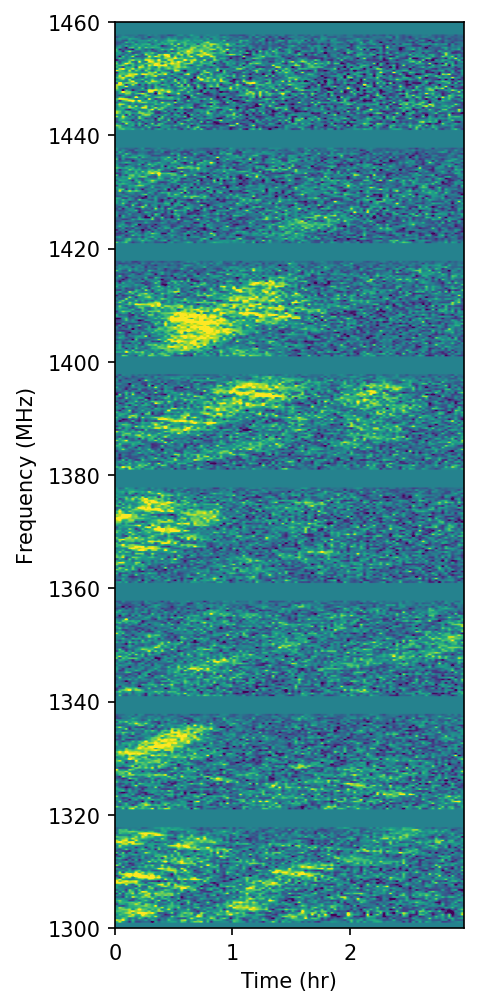

In [36]:
real_spec=dsa.load_triple_spectrum(list_obs[55], factor=[1,1], wnoise=True, mean0=True)
real_spec.I=real_spec.I+(1-real_spec.I.mean())
my_spec=real_spec.shrink([10,1])
my_spec.ss=my_spec.make_ss()

real_spec.shrink([10,1]).plot_ds()

In [132]:
def fit_spec(my_spec, par_lims=[0.5,5.5], edge=1.4, ntau=512, d_eff=0.325*u.pc, mean0=True,
             curv_par='dveff', chi2_method='Nina',reduced=True, chi2svd=False,
             edge_threshold=False, tau_ed=0.25, model_ev=True, plot_res=False):
    if mean0 is True:
        my_spec.I=my_spec.I-np.mean(my_spec.I)
    fitdic, fit_f, fit_t, dic_res=fth.daniel_pars_fit(my_spec, par_lims=par_lims,edge=edge,ntau=ntau,
                                                      curv_par=curv_par, chi2_method=chi2_method,
                                                      reduced=reduced, chi2svd=chi2svd,
                                                      edge_threshold=edge_threshold, tau_ed=tau_ed)
    print (fit_f, fit_t)
    print ('eta  : %.3f'%fitdic['eta'].value, fitdic['eta'].unit, 'e_err: %.3f'%fitdic['eta_err'].value)
    print ('mueff: %.3f'%fitdic['mueff'].value, fitdic['mueff'].unit,'m_err: %.3f'%fitdic['mueff_err'].value)
    print ('dveff: %.3f'%fitdic['dveff'].value, fitdic['dveff'].unit,'v_err: %.3f'%fitdic['dveff_err'].value)
    
    eta_load=fitdic['eta']
    model_spec=mth.get_models_spec(spec_sel,eta_load,edge=edge,ntau=ntau,model_ev=model_ev)
    
    return fitdic, fit_f, fit_t, dic_res, model_spec

In [129]:
def plot_fit_res(my_spec, fitdic, dic_res, model_spec, edge=1.4, ntau=512):
    fig=plt.figure(figsize=(6,11), dpi=90)
    
    plt.figtext(0.25,1.16,'MJD: %.2f, freq: %.2f, dveff: %.2f, eta: %.2f'
                %(my_spec.mjd.mjd.mean(),my_spec.f.mean().value,fitdic['dveff'].value, fitdic['eta'].value),
               fontsize=15)
    fig.add_axes([0.0,1.0,0.37, 0.15])
    frame1=plt.gca()
    my_spec.plot_ds(new_fig=False)
    
    fig.add_axes([0.5,1.0,0.37, 0.15])
    frame1=plt.gca()
    model_spec.plot_mds(new_fig=False)
    
    fig.add_axes([1.0,1.0,0.37, 0.15])
    frame1=plt.gca()
    model_spec.plot_me(new_fig=False)
    
    fig.add_axes([0.0,0.8,0.45, 0.15])
    frame1=plt.gca()
    my_spec.plot_ss(new_fig=False)
    
    fig.add_axes([0.5,0.8,0.45, 0.15])
    frame1=plt.gca()
    model_spec.plot_mss(new_fig=False)
    
    fig.add_axes([1.0,0.8,0.45, 0.15])
    frame1=plt.gca()
    my_spec.plot_ss(new_fig=False)
    plt.plot(my_spec.ss.fd,fitdic['eta'].value*(my_spec.ss.fd**2),'r',lw=2)
    
    fig.add_axes([0.0,0.38,0.45, 0.15])
    frame1=plt.gca()
    mth.plot_etas(dic_res,new_fig=False)
    
    fig.add_axes([0.5,0.38,0.45, 0.15])
    frame1=plt.gca()
    model_spec.plot_mes(new_fig=False, cb=True)
    
    mE, mEs, me_tau, me_fd =model_spec.mE.T, model_spec.mEs, model_spec.tau, model_spec.fd
    mEs_2=np.abs(mEs)**2
    mE=mE/np.mean(np.abs(mE))
    dspec=my_spec.I.T
    gx=mE
    gx[dspec>0]=dspec[dspec>0]*np.exp(1j*np.angle(mE[dspec>0]))
    gx[dspec<0]=0.0
    gx_mEs, me_tau, me_fd =dsa.fun_make_ss(gx.T, my_spec.t, my_spec.f)
    fac_norm=np.mean(np.abs(gx_mEs)**2)/np.mean(mEs_2)
    gx_mEs_2=np.abs(gx_mEs)**2/fac_norm
    
    fig.add_axes([1.0,0.38,0.45, 0.15])
    frame1=plt.gca()
    vmin,vmax=np.percentile(gx_mEs_2, [20,100-3e-2])
    mth.fun_plot_mes(gx_mEs_2, me_fd, me_tau, cb=True, vmin=vmin,vmax=vmax, new_fig=False)
    plt.title('$|\^w_{deconv}|^2$')

    
    edges=np.linspace(-edge,edge,ntau)    
    thth_red, thth2_red, recov, model, edges_red,w,V = THTH.modeler(my_spec.ss.Is, my_spec.ss.tau,
                                                                    my_spec.ss.fd,
                                                               eta=fitdic['eta'], edges=edges)
    ththE_red=thth_red*0
    ththE_red[ththE_red.shape[0]//2,:]=np.conjugate(V)*np.sqrt(w)
    thth_derot=thth_red*np.conjugate(thth2_red)
    
    fig.add_axes([0.0,0.6,0.25, 0.14])
    frame1=plt.gca()
    plt.imshow(np.abs(thth_red)**2,norm=LogNorm(),origin='lower',aspect='auto',
            extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
            vmin=np.median(np.abs(thth_red)**2),vmax=np.abs(thth_red).max()**2)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'Data $\theta-\theta$')
    
    fig.add_axes([0.375,0.6,0.25, 0.14])
    frame1=plt.gca()
    plt.imshow(np.abs(thth2_red)**2,norm=LogNorm(),origin='lower',aspect='auto',
            extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
            vmin=np.median(np.abs(thth_red)**2),vmax=np.abs(thth_red).max()**2)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'Model $\theta-\theta$')
    
    fig.add_axes([0.75,0.6,0.25, 0.14])
    frame1=plt.gca()
    plt.imshow(thth_derot.real,norm=SymLogNorm(np.median(np.abs(thth_red)**2)),
            origin='lower',aspect='auto',
            extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
               vmin=-np.abs(thth_derot).max(),vmax=np.abs(thth_derot).max())
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'Derotated $\theta-\theta$ (real)')
    
    fig.add_axes([1.125,0.6,0.25, 0.14])
    frame1=plt.gca()
    plt.imshow(thth_derot.imag,
            norm=SymLogNorm(np.median(np.abs(thth_red)**2)),origin='lower',aspect='auto',
            extent=[edges_red[0],edges_red[-1],edges_red[0],edges_red[-1]],
               vmin=-np.abs(thth_derot).max(),vmax=np.abs(thth_derot).max())
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(r'Derotated $\theta-\theta$ (imag)')

    

In [133]:
real_spec=dsa.load_triple_spectrum(list_obs[55], factor=[1,1], wnoise=True, mean0=True)
my_spec=real_spec.shrink([5,1])
my_spec.ss=my_spec.make_ss()

new_sp_pieces=np.empty((real_spec.subbands.shape[0]-1, 2), dtype=int)
ch_sz=int(my_spec.f.size/real_spec.subbands.shape[0])
for i in range(0,new_sp_pieces.shape[0]):
    new_sp_pieces[i,:]=[i*ch_sz,i*ch_sz+ch_sz*3]
spec_pieces=new_sp_pieces
spec_sel=my_spec.select(freq_idx=[spec_pieces[3,0],spec_pieces[3,1]])

fitdic, fit_f, fit_t, dic_res, model_spec=fit_spec(spec_sel)

(1079, 512)
(1079, 512)
(1079, 512)
(215, 512)
(215, 512)
fit: <Dynamic spectrum: Dur: 3.00 hr, Freq: 1360.12 - 1420 MHz, MJD: 56088.58, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1390.019569471624 MHz 56088.58078702903
eta  : 2.459 us / mHz2 e_err: 0.000
mueff: 11.546 mas / yr m_err: 0.000
dveff: 0.987 km / (pc(1/2) s) v_err: 0.000


In [136]:
real_spec=dsa.load_triple_spectrum(list_obs[55], factor=[1,1], wnoise=True, mean0=True)
my_spec=real_spec.shrink([5,1])
my_spec.ss=my_spec.make_ss()

new_sp_pieces=np.empty((real_spec.subbands.shape[0]-1, 2), dtype=int)
ch_sz=int(my_spec.f.size/real_spec.subbands.shape[0])
for i in range(0,new_sp_pieces.shape[0]):
    new_sp_pieces[i,:]=[i*ch_sz,i*ch_sz+ch_sz*3]
spec_pieces=new_sp_pieces
spec_sel=my_spec.select(freq_idx=[spec_pieces[3,0],spec_pieces[3,1]])

fitdic, fit_f, fit_t, dic_res, model_spec=fit_spec(spec_sel, chi2svd=True)

(1079, 512)
(1079, 512)
(1079, 512)
(215, 512)
(215, 512)
fit: <Dynamic spectrum: Dur: 3.00 hr, Freq: 1360.12 - 1420 MHz, MJD: 56088.58, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


/mnt/scratch-lustre/dbaker/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1390.019569471624 MHz 56088.58078702903
eta  : 0.079 us / mHz2 e_err: nan
mueff: 64.364 mas / yr m_err: nan
dveff: 5.500 km / (pc(1/2) s) v_err: nan


/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3

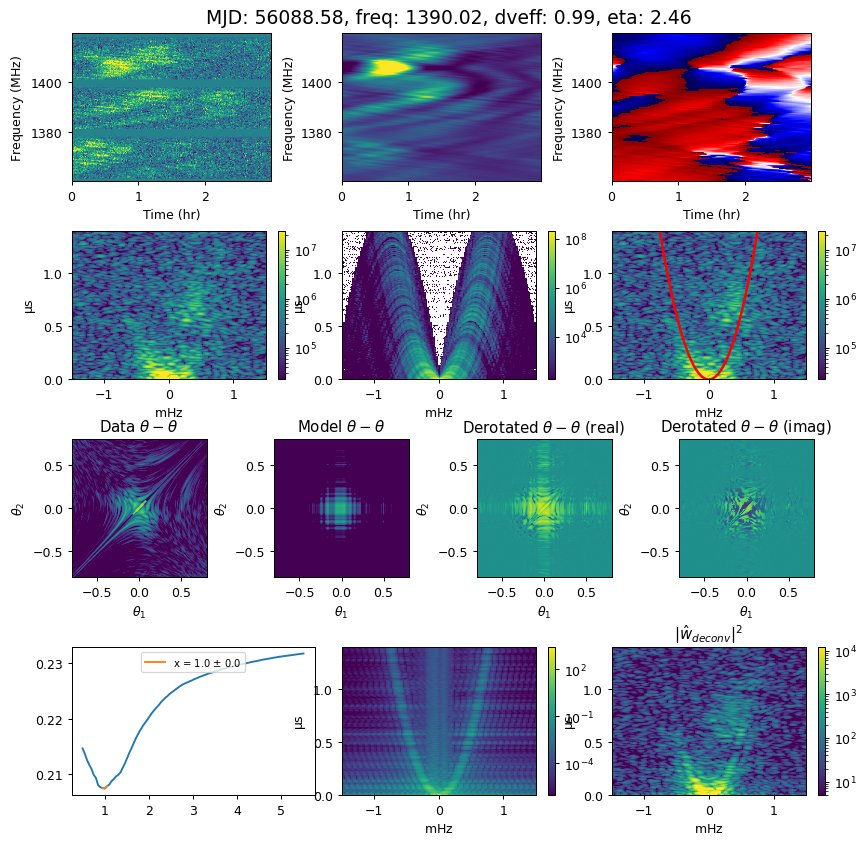

In [135]:
plot_fit_res(spec_sel, fitdic, dic_res, model_spec)

/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/opt/python/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3

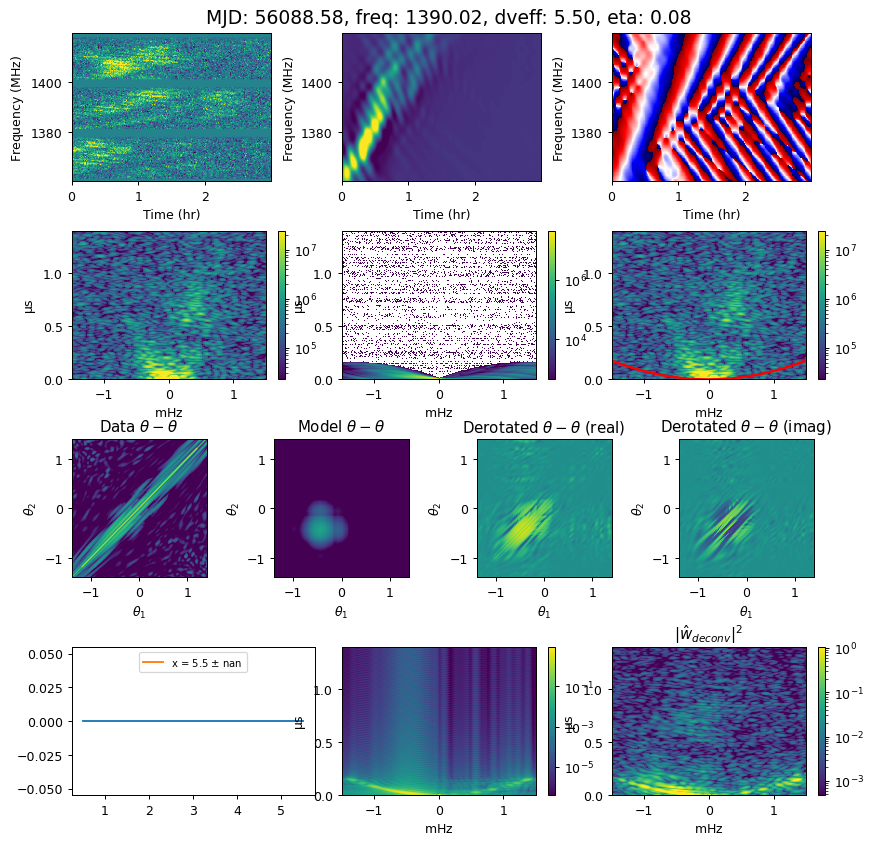

In [137]:
plot_fit_res(spec_sel, fitdic, dic_res, model_spec)

In [ ]:
thth_model=svd_model(thth_red)

In [ ]:
chisq_old=np.zeros(etas.shape[0])
chisq=np.zeros(etas.shape[0])
for i in range(etas.shape[0]):
    eta=etas[i]
    chisq_old[i]=THTH.Eval_calc(CS, tau, fd, eta, edges)
    thth_red, edges_red1, edges_red2 = THTH.two_curve_map(CS, tau, fd, eta,
                                                edges1, eta, edges2)
    cents1=(edges_red1[1:]+edges_red1[:-1])/2
    thth_red[:,np.abs(cents1)<=3]=0
    U,S,W=np.linalg.svd(thth_red)
    chisq[i]=S[0]

In [ ]:
  for i in range(0,spec_pieces.shape[0]):
        spec_sel=my_spec.select(freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

        if ind_mean0 is True:
            spec_sel.I=spec_sel.I-np.mean(spec_sel.I)
            spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)
        fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
        frame1=plt.gca()
        spec_sel.plot_ss(new_fig=False, cb=False,fd_lim=[-2.0,2.0],tau_lim=[0.0,1.3],vmin=vmin_ss,vmax=vmax_ss)
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])
        if load_model is False:
            fitdic, fit_f, fit_t, dic_res=fth.daniel_pars_fit(spec_sel, par_lims=par_lims,
                                                              edge=edge,ntau=ntau,curv_par=curv_par,
                                                              chi2_method=chi2_method, reduced=reduced,
                                                              edge_threshold=edge_threshold, tau_ed=tau_ed)
            if np.isnan(fitdic['eta']):
                print ('the fit did not converge, not correct eta, skip this spw')
            else:
                f.write('%.3f, %.3f, %.3f, %.3f, %.3f, %.3f  \n'%(fitdic['eta'].value,
                            fitdic['eta_err'].value,fitdic['dveff'].value, fitdic['dveff_err'].value,
                                                     fit_f.value,fit_t))
                dics_res.append(dic_res)
                dics_res_a.append(dic_res)

            if np.isfinite(fitdic['eta']):
                res_fit.append(fitdic)
                res_f.append(fit_f)
                res_f_a.append(fit_f)
                res_t.append(fit_t)


                print (fit_f, fit_t)
                print ('eta  : %.3f'%fitdic['eta'].value, fitdic['eta'].unit,
                       'mueff: %.3f'%fitdic['mueff'].value, fitdic['mueff'].unit,
                       'dveff: %.3f'%fitdic['dveff'].value, fitdic['dveff'].unit)
                print ('e_err: %.3f'%fitdic['eta_err'].value, fitdic['eta'].unit,
                       'm_err: %.3f'%fitdic['mueff_err'].value, fitdic['mueff'].unit,
                       'v_err: %.3f'%fitdic['dveff_err'].value, fitdic['dveff'].unit)
                eta_load=fitdic['eta']

        else:
            eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
            eta_err=0.0*eta.unit
            eta_f=np.mean(spec_sel.f)
                     eta_f=np.mean(spec_sel.f)
            eta_t=np.mean(spec_sel.mjd.mjd)
            eta_load=eta
            print ('%.2f MHz'%eta_f.value, 'eta: %.3f'%eta_load.value, eta_load.unit)

        if np.isfinite(eta_load):
            model_spec=mth.get_models_spec(spec_sel,eta_load,edge=edge,ntau=ntau,model_ev=model_ev)
            models_e_a.append(model_spec.mE.T)
            h_ds=0.105
            if pc_overlap is True:
                h_ds=0.23
            fig.add_axes([0.3,0.006+0.125*i,0.25, h_ds])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            plt.xlabel('')
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.85,0.006+0.125*i,0.2, 0.105])
            if save_models is True:
                all_models.append(model_spec)
            if load_model is False:
                frame1=plt.gca()
                mth.plot_etas(dic_res,new_fig=False)
                frame1.axes.get_xaxis().set_ticks([])
            else:
                aux_name=aux_name+'%.1f'%eta_load.value
        print ('----------')
    if load_model is False:
        fig.add_axes([2.2,0.625,0.25, 0.125])
        frame1=plt.gca()
        chi2sg=np.empty((len(dics_res_a),100))
        for g in range(0,len(dics_res_a)):
            chi2sg[g,:]=dics_res_a[g]['chi2']
            plt.plot(dics_res_a[g]['par_array'],dics_res_a[g]['chi2'], label ='%.2f MHz'%res_f_a[g].value)
            plt.legend(loc=(0.0,1.1))
        fig.add_axes([2.2,0.45,0.25, 0.125])
        frame1=plt.gca()
        sim_fit = fth.parabola_fit(dics_res_a[0]['par_array'],chi2sg.mean(0))
        plt.plot(dics_res_a[0]['par_array'],chi2sg.mean(0), label='x=%.1f pm %.1f'%(sim_fit[0].value, sim_fit[1].value))
        plt.legend(fontsize=8, loc='upper center')
    fig.add_axes([2.2,0.26,0.25, 0.15])
    frame1=plt.gca()
    my_spec.plot_ss(new_fig=False, cb=False,vmin=vmin_ss,vmax=vmax_ss)




In [ ]:
fit_two_screen()

In [15]:
real_spec=dsa.load_triple_spectrum(list_obs[55], factor=[1,1], wnoise=True, mean0=True)
#real_spec.I=real_spec.I+(1-real_spec.I.mean())
my_spec=real_spec.shrink([5,1])
my_spec.ss=my_spec.make_ss()

new_sp_pieces=np.empty((real_spec.subbands.shape[0]-1, 2), dtype=int)
ch_sz=int(my_spec.f.size/real_spec.subbands.shape[0])
for i in range(0,new_sp_pieces.shape[0]):
    new_sp_pieces[i,:]=[i*ch_sz,i*ch_sz+ch_sz*2]
spec_pieces=new_sp_pieces

time=real_spec.t
freq=real_spec.f
dspec=real_spec.I.T
eta1_ref=9.73*u.us/u.mHz**2
eta2_ref=1.69*u.us/u.mHz**2
ref_freq=1379*u.MHz



models_e_a=[]
models_ds_a=[]


edge1=0.35
edge2=0.9
ntau=512
edges1=np.linspace(-edge1,edge1,ntau)
edges2=np.linspace(-edge2,edge2,ntau)
edges1, edges2=edges1, edges2


chi2_array=np.zeros((20,20))
eta1_ref_array=np.linspace(9.73-3,9.73-3,20)*u.us/u.mHz**2
eta2_ref_array=np.linspace(1.69-1,1.69+1,20)*u.us/u.mHz**2

for l in range(0,20):
    for h in range(0,20):
        for i in range(3,4):
            spec_sel=my_spec.select(freq_idx=[spec_pieces[i,0],spec_pieces[i,1]])
            eta1=eta1_ref_array[l]*(ref_freq/spec_sel.f.mean())**2
            eta2=eta2_ref_array[h]*(ref_freq/spec_sel.f.mean())**2
            time=spec_sel.t
            freq=spec_sel.f
            dspec=spec_sel.I.T
            SS=np.fft.fftshift((np.fft.fft2(dspec)))

            fd=THTH.fft_axis(time,u.mHz)
            tau=THTH.fft_axis(freq,u.us)

            ext_d=THTH.ext_find(time.to(u.hour),freq)
            ext_f=THTH.ext_find(fd,tau)

            thth=thth_map2(SS, tau, fd, eta1, edges1,eta2,edges2)
            thth_red,edges_red1,edges_red2=two_curve_map(SS, tau, fd, eta1, edges1,eta2,edges2)
            recov=rev_map2(thth, tau, fd, eta1, edges1, eta2, edges2,isdspec=True)
            model_modeler=np.fft.ifft2(np.fft.ifftshift(recov)).real

            model_E, model_ds, model_ss, model_field, model_E_ev, model_field_ev=get_models_from_recov(recov,
                                                                                                       dspec)
            
            chi2_array[l,h]=np.sum(((model_modeler-dspec)**2)/dspec.size)
            print ('right now in etas:',l,h, '%.3e'%chi2_array[l,h])

(1079, 512)
(1079, 512)
(1079, 512)
(215, 512)
(215, 512)
right now in etas: 0 0 4.807e+00
right now in etas: 0 1 4.813e+00
right now in etas: 0 2 4.805e+00
right now in etas: 0 3 4.790e+00
right now in etas: 0 4 4.771e+00
right now in etas: 0 5 4.754e+00
right now in etas: 0 6 4.741e+00
right now in etas: 0 7 4.726e+00
right now in etas: 0 8 4.708e+00
right now in etas: 0 9 4.693e+00
right now in etas: 0 10 4.669e+00
right now in etas: 0 11 4.656e+00
right now in etas: 0 12 4.641e+00
right now in etas: 0 13 4.638e+00
right now in etas: 0 14 4.630e+00
right now in etas: 0 15 4.620e+00
right now in etas: 0 16 4.619e+00
right now in etas: 0 17 4.627e+00
right now in etas: 0 18 4.619e+00
right now in etas: 0 19 4.620e+00
right now in etas: 1 0 4.807e+00
right now in etas: 1 1 4.813e+00
right now in etas: 1 2 4.805e+00
right now in etas: 1 3 4.790e+00
right now in etas: 1 4 4.771e+00
right now in etas: 1 5 4.754e+00
right now in etas: 1 6 4.741e+00
right now in etas: 1 7 4.726e+00
right no

right now in etas: 12 2 4.805e+00
right now in etas: 12 3 4.790e+00
right now in etas: 12 4 4.771e+00
right now in etas: 12 5 4.754e+00
right now in etas: 12 6 4.741e+00
right now in etas: 12 7 4.726e+00
right now in etas: 12 8 4.708e+00
right now in etas: 12 9 4.693e+00
right now in etas: 12 10 4.669e+00
right now in etas: 12 11 4.656e+00
right now in etas: 12 12 4.641e+00
right now in etas: 12 13 4.638e+00
right now in etas: 12 14 4.630e+00
right now in etas: 12 15 4.620e+00
right now in etas: 12 16 4.619e+00
right now in etas: 12 17 4.627e+00
right now in etas: 12 18 4.619e+00
right now in etas: 12 19 4.620e+00
right now in etas: 13 0 4.807e+00
right now in etas: 13 1 4.813e+00
right now in etas: 13 2 4.805e+00
right now in etas: 13 3 4.790e+00
right now in etas: 13 4 4.771e+00
right now in etas: 13 5 4.754e+00
right now in etas: 13 6 4.741e+00
right now in etas: 13 7 4.726e+00
right now in etas: 13 8 4.708e+00
right now in etas: 13 9 4.693e+00
right now in etas: 13 10 4.669e+00
rig

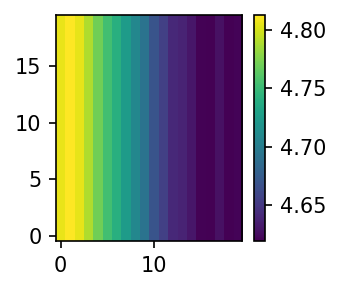

In [16]:
plt.figure(figsize=(2,2), dpi=150)

plt.imshow(chi2_array, aspect='auto',origin='lower')

plt.colorbar()

In [ ]:
plt.figure(figsize=(2,2), dpi=150)

plt.imshow(chi2_array, aspect='auto',origin='lower', extent=[eta2_ref_array[0].value,eta2_ref_array[-1].value,
                                               eta1_ref_array[0].value,eta1_ref_array[-1].value])

plt.colorbar()

In [42]:
real_spec=dsa.load_triple_spectrum(list_obs[55], factor=[1,1], wnoise=True, mean0=True)
real_spec.I=real_spec.I+(1-real_spec.I.mean())
my_spec=real_spec.shrink([5,1])
my_spec.ss=my_spec.make_ss()

time=real_spec.t
freq=real_spec.f
dspec=real_spec.I.T
eta1_ref=9.73*u.us/u.mHz**2
eta2_ref=1.69*u.us/u.mHz**2

ref_freq=1379*u.MHz

new_sp_pieces=np.empty((real_spec.subbands.shape[0]-1, 2), dtype=int)
ch_sz=int(my_spec.f.size/real_spec.subbands.shape[0])
for i in range(0,new_sp_pieces.shape[0]):
    new_sp_pieces[i,:]=[i*ch_sz,i*ch_sz+ch_sz*2]
spec_pieces=new_sp_pieces

models_e_a=[]
models_ds_a=[]


edge1=0.85
edge2=1.4
ntau=512
edges1=np.linspace(-edge1,edge1,ntau)
edges2=np.linspace(-edge2,edge2,ntau)
edges1, edges2=edges1, edges2


chi2_array=np.zeros((10,10))
eta1_ref_array=np.linspace(7.0,9.73,10)*u.us/u.mHz**2
eta2_ref_array=np.linspace(0.5,1.69,10)*u.us/u.mHz**2


for i in range(0,1):
    spec_sel=my_spec.select(freq_idx=[spec_pieces[i,0],spec_pieces[i,1]])
    eta1=eta1_ref*(ref_freq/spec_sel.f.mean())**2
    eta2=eta2_ref*(ref_freq/spec_sel.f.mean())**2
    time=spec_sel.t
    freq=spec_sel.f
    dspec=spec_sel.I.T
    SS=np.fft.fftshift(np.fft.fft2(dspec))

    fd=THTH.fft_axis(time,u.mHz)
    tau=THTH.fft_axis(freq,u.us)

    ext_d=THTH.ext_find(time.to(u.hour),freq)
    ext_f=THTH.ext_find(fd,tau)

    thth=THTH.thth_map2(SS, tau, fd, eta1, edges1,eta2,edges2)
    thth_red,edges_red1,edges_red2=THTH.two_curve_map(SS, tau, fd, eta1, edges1,eta2,edges2)
    recov=THTH.rev_map2(thth, tau, fd, eta1, edges1, eta2, edges2,isdspec=True)
    model_modeler=np.fft.ifft2(np.fft.ifftshift(recov)).real

    model_E, model_ds, model_ss, model_field, model_E_ev, model_field_ev=get_models_from_recov(recov,
                                                                                               dspec)

(1079, 512)
(1079, 512)
(1079, 512)
(215, 512)
(215, 512)


In [ ]:
thth_model=svd_model(thth_red)

In [ ]:
def nina_get_svd(ds, SS,tau,fd, eta, edge=1.4, ntau=512, fd2=None,tau2=None, plot_mds=False, ns=None,
reduced=True, eta_2=None, edge2=None):
    if eta_2 == None:
        eta_2=eta
    edges=np.linspace(-edge,edge,ntau)
    if edge_2 == None:
        edges_2=edges
    thth_red, edges_red1, edges_red2 = THTH.two_curve_map(SS, tau, fd, eta,
                                                edges1, eta_2, edges2)
    cents1=(edges_red1[1:]+edges_red1[:-1])/2
    thth_red[:,np.abs(cents1)<=3]=0
    U,S,W=np.linalg.svd(thth_red)
    chisq_svd[i]=S[0]
    return chisq_svd


In [43]:
me_f= np.linspace(spec_sel.f[0],spec_sel.f[-1], model_E.shape[0])
me_t= spec_sel.t
npad=3
model_E_pad=np.pad(model_E.T,((0,npad*model_E.T.shape[0]),(0,npad*model_E.T.shape[1])),mode='constant',
                        constant_values=model_E.T.mean())
model_E_pad=model_E_pad.T
me_fd=THTH.fft_axis(me_t,u.mHz,npad)
me_tau=THTH.fft_axis(me_f,u.us,npad)

model_field_yes=np.fft.fftshift(np.fft.fft2(model_E_pad))


model_Eev_pad=np.pad(model_E_ev.T,((0,npad*model_E_ev.T.shape[0]),(0,npad*model_E_ev.T.shape[1])),
                     mode='constant',
                        constant_values=model_E_ev.T.mean())
model_Eev_pad=model_Eev_pad.T
model_field_ev_yes=np.fft.fftshift(np.fft.fft2(model_Eev_pad))

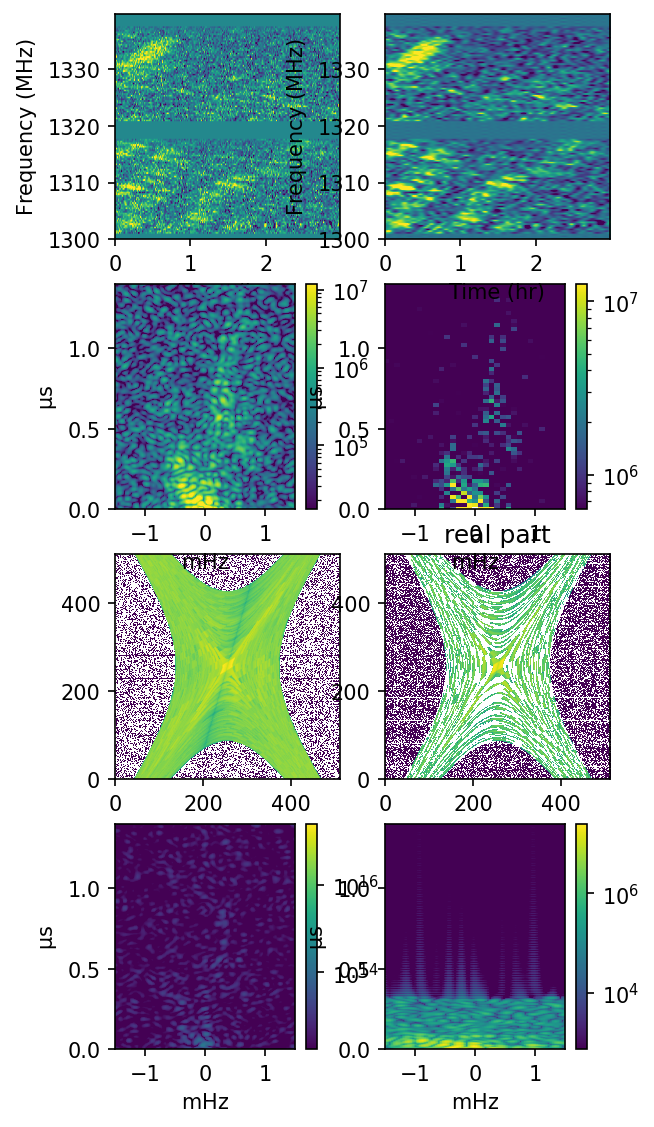

In [44]:
fig=plt.figure(figsize=(3,3), dpi=150)

ax1=fig.add_axes([0.0,0.0,0.5,0.5])
plt.gca()
plt.imshow(np.abs(thth)**2,
        norm=LogNorm(),
        origin='lower',
        aspect='auto')


ax1=fig.add_axes([0.6,0.0,0.5,0.5])
plt.gca()
plt.imshow(np.real(thth),
        norm=LogNorm(),
        origin='lower',
        aspect='auto')
plt.title('real part')

ax2=fig.add_axes([0.0,1.2,0.5,0.5])
plt.gca()
spec_sel.plot_ds(new_fig=False)

ax2=fig.add_axes([0.0,0.6,0.5,0.5])
plt.gca()
spec_sel.plot_ss(new_fig=False)

ax2=fig.add_axes([0.0,-0.6,0.5,0.5])
plt.gca()
mth.fun_plot_mes(np.abs(model_field_yes)**2, fd, tau, new_fig=False)
ax2=fig.add_axes([0.6,-0.6,0.5,0.5])
plt.gca()
mth.fun_plot_mes(np.abs(model_field_ev_yes)**2, fd, tau, new_fig=False)
ax2=fig.add_axes([0.6,0.6,0.5,0.5])
plt.gca()
mth.fun_plot_mes(np.abs(model_ss)**2, fd, tau, new_fig=False)

ax2=fig.add_axes([0.6,1.2,0.5,0.5])
plt.gca()
dsa.fun_plot_ds(model_ds.T, spec_sel.t, spec_sel.f, new_fig=False)